# Rat RNN

### Load Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from unityagents import UnityEnvironment

%matplotlib inline

### Start Environment

In [2]:
env_name = "rat" # Name of the Unity environment binary to launch
env = UnityEnvironment(file_name=env_name, worker_id=1)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]

INFO:unityagents.environment:
'Academy' started successfully!


Unity Academy name: Academy
        Number of brains: 1
        Reset Parameters :
		
Unity brain name: Brain
        Number of observations (per agent): 0
        State space type: continuous
        State space size (per agent): 6
        Action space type: continuous
        Action space size (per agent): 1
        Memory space size (per agent): 0
        Action descriptions: 


### Collect States

In [3]:
x,z,ep = [], [], []
input_x = []
a = env.reset()
for i in range(10000):
    a = env.step()[default_brain]
    x.append(a.states[0][0])
    z.append(a.states[0][1])
    input_x.append(a.states[0][2:-1])
    ep.append(a.states[0][-1])

In [4]:
x = np.array(x)
z = np.array(z)
input_x = np.array(input_x)
input_y = np.stack((x, z), axis=1)

### Visualize Rat Trajectory

In [5]:
def create_colors(length=10000, segments=100):
    c_list = []
    for i in range(segments):
        color = np.zeros([length//segments, 4])
        color[:, 3] = 0.5
        color[:, 0:3] = np.random.uniform(0, 1, size=[1, 3])
        c_list.append(color)
    c_list = np.reshape(c_list, [length, 4])
    return c_list

(-4, 4)

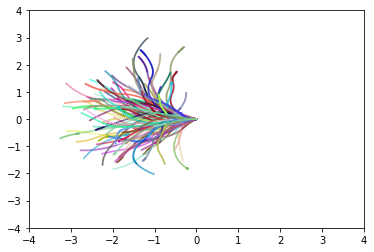

In [6]:
plt.scatter(x, z, s=1, c=create_colors())
plt.ylim(-4, 4)
plt.xlim(-4, 4)

### Define Network

In [7]:
class RatRNN(object):
    def __init__(self, x_size, y_size, h_size, lr):
        self.x = tf.placeholder(shape=[None, x_size], dtype=tf.float32)
        self.train_length = tf.placeholder(shape=[1], dtype=tf.int32)
        self.batch_size = tf.placeholder(shape=[1], dtype=tf.int32)

        self.rnn_in = tf.reshape(self.x, shape=[self.batch_size[0], self.train_length[0], x_size])

        cell = tf.contrib.rnn.BasicLSTMCell(h_size, state_is_tuple=True)
        self.state_in = cell.zero_state(self.batch_size[0], tf.float32)

        self.rnn, self.rnn_state = tf.nn.dynamic_rnn(inputs=self.rnn_in, cell=cell, dtype=tf.float32,
                                                     initial_state=self.state_in)

        self.output = tf.reshape(self.rnn, shape=[-1, h_size])
        
        self.y_pred = tf.layers.dense(self.output, y_size, activation=None)

        self.y = tf.placeholder(shape=[None, y_size], dtype=tf.float32)

        l2_loss_a = tf.reduce_sum(tf.nn.l2_loss(tf.trainable_variables()[0]))
        l2_loss_b = tf.reduce_sum(tf.nn.l2_loss(tf.trainable_variables()[1]))
        self.l2_loss = l2_loss_a + l2_loss_b
        self.regress_loss = tf.reduce_sum(tf.squared_difference(self.y, self.y_pred))
        self.loss = self.regress_loss + self.l2_loss

        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optimizer.minimize(self.loss)

### Train Network

In [8]:
# Hyperparameters
learning_rate = 1e-3
hidden_units = 64
num_steps = 200

63.5565
77.4949
67.0826
61.8185
77.8632
170.797
57.6737
78.0568
91.9748
65.5351
73.2268
58.2897
45.4868
62.4102
33.5119
49.4303
31.0778
34.1179
26.7299


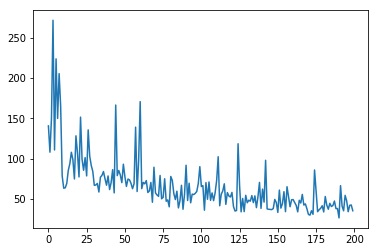

In [9]:
tf.reset_default_graph()

rat_rnn = RatRNN(3, 2, hidden_units, learning_rate)

init = tf.global_variables_initializer()

losses = []

sess = tf.InteractiveSession()    
sess.run(init)
for i in range(num_steps):
    pointer = np.random.randint(0, 100)
    batch_x = input_x[pointer*100:(pointer+1)*100]
    batch_y = input_y[pointer*100:(pointer+1)*100]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,3]), rat_rnn.y: np.reshape(batch_y, [-1, 2]), 
                 rat_rnn.train_length: [100], rat_rnn.batch_size: [1]}
    loss, _ = sess.run([rat_rnn.loss, rat_rnn.update], feed_dict=feed_dict)
    if i % 10 == 0 and i != 0:
        print(loss)
    losses.append(loss)
plt.plot(losses)

### Compare Trajectories

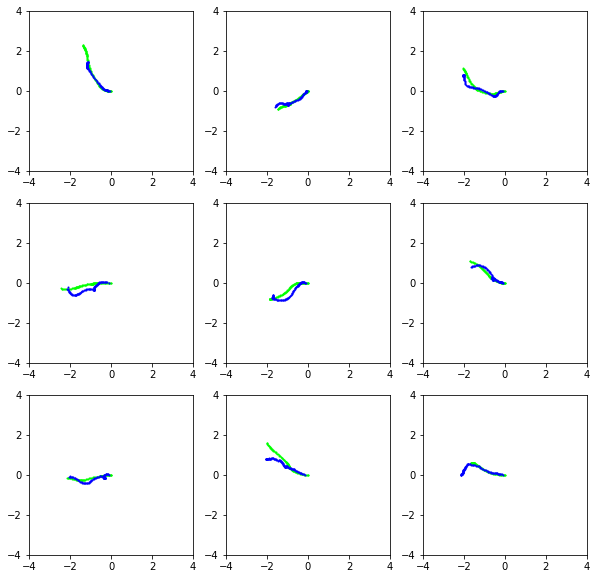

In [32]:
pointer = 6
plt.figure(figsize=(10,10))
for i in range(9):
    pointer = i
    batch_x = input_x[pointer*100:(pointer+1)*100]
    batch_y = input_y[pointer*100:(pointer+1)*100]
    feed_dict = {rat_rnn.x: np.reshape(batch_x, [-1,3]), 
                 rat_rnn.train_length: [100], rat_rnn.batch_size: [1]}
    yp = sess.run(rat_rnn.y_pred, feed_dict=feed_dict)
    
    # Real - Green | Predicted - Blue
    plt.subplot(331 + i)
    plt.scatter(batch_y[:,0], batch_y[:, 1], s=1, c=[0,1,0,1])
    plt.scatter(yp[:, 0], yp[:, 1], s=1, c=[0,0,1,1])
    plt.ylim(-4, 4)
    plt.xlim(-4, 4)
plt.show()

### Close TensorFlow Session & Environment

In [ ]:
sess.close()
env.close()